In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Analysing FICO Score: Bucketing FICO Scores of Loan Borrowers
### Task 4:
Charlie wants to make her model work for future data sets, so she needs a general approach to generating the buckets. Given a set number of buckets corresponding to the number of input labels for the model, she would like to find out the boundaries that best summarize the data.

You need to create a rating map that maps the FICO score of the borrowers to a rating where a lower rating signifies a better credit score.

The process of doing this is known as quantization. You could consider many ways of solving the problem by optimizing different properties of the resulting buckets, such as the mean squared error or log-likelihood.

In [2]:
# Function to calculate the log-likelihood for a given number of observations and defaults
def log_likelihood(n, k):
    p = k / n if n != 0 else 0
    if p == 0 or p == 1:
        return 0
    return k * np.log(p) + (n - k) * np.log(1 - p)

# Load the data from a CSV file into a DataFrame
dataframe = pd.read_csv('Task3n4_Loan_Data.csv')

# Extract the 'default' and 'fico_score' columns as lists
x = dataframe['default'].to_list()  # 1 if defaulted, 0 otherwise
y = dataframe['fico_score'].to_list()  # FICO scores
n = len(x)  # Number of records

# Initialize lists to store cumulative counts of defaults and total records for each FICO score
default = [0 for i in range(551)]       # as FICO score range 300 to 850
total = [0 for i in range(551)]

# Populate the 'default' and 'total' lists
for i in range(n):
    y[i] = int(y[i])
    default[y[i] - 300] += x[i]
    total[y[i] - 300] += 1

# Compute cumulative sums for 'default' and 'total' lists
for i in range(1, 551):
    default[i] += default[i - 1]
    total[i] += total[i - 1]

# Number of partitions to find
r = 10
# Initialize DP table with very low initial value
dp = [[[-10**18, 0] for _ in range(551)] for _ in range(r + 1)]

# Fill the DP table
for i in range(r + 1):  # For each number of partitions from 0 to r
    for j in range(551):  # For each FICO score index
        if i == 0:
            dp[i][j][0] = 0  # Base case: no partitions, log-likelihood is 0
        else:
            for k in range(j):  # Previous FICO score index
                if total[j] == total[k]:
                    continue  # Skip if total counts are equal (prevent division by zero)
                if i == 1:
                    dp[i][j][0] = log_likelihood(total[j], default[j])
                else:
                    # Update DP value considering partition at index k
                    potential_value = log_likelihood(total[j] - total[k], default[j] - default[k]) + dp[i - 1][k][0]
                    if dp[i][j][0] < potential_value:
                        dp[i][j][0] = potential_value
                        dp[i][j][1] = k

# Retrieve the best log-likelihood value found
best_value = round(dp[r][550][0], 4)
print(f"Best log-likelihood: {best_value}")

# Trace back to find the optimal partition points
k = 550
buckets = []
while r >= 0:
    buckets.append(k + 300)  # Convert FICO index back to FICO score
    k = dp[r][k][1]  # Move to the previous partition index
    r -= 1

# Print the bucket boundaries in ascending order
buckets = sorted(buckets)
print(f"Bucket boundaries: {buckets}")


Best log-likelihood: -4217.8245
Bucket boundaries: [300, 520, 552, 580, 611, 649, 696, 732, 752, 753, 850]


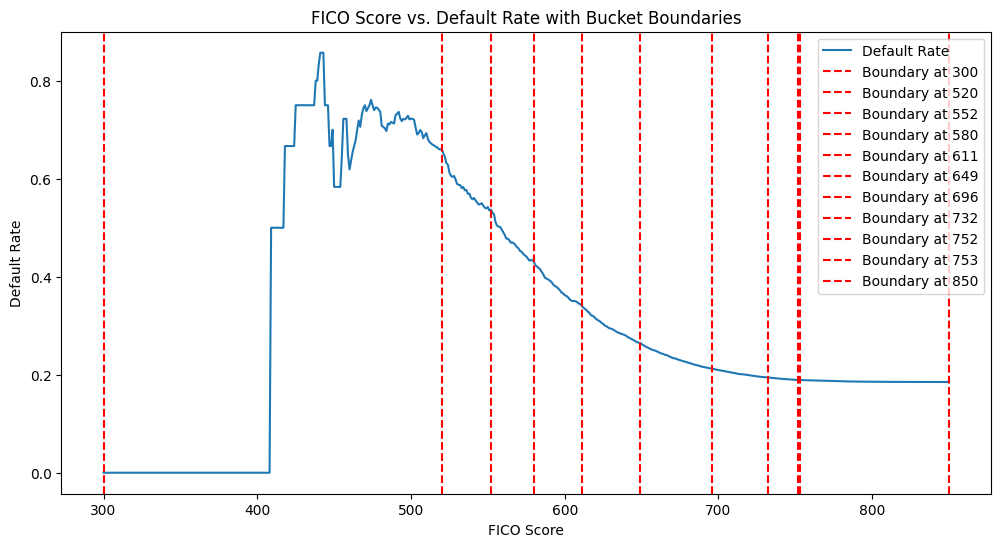

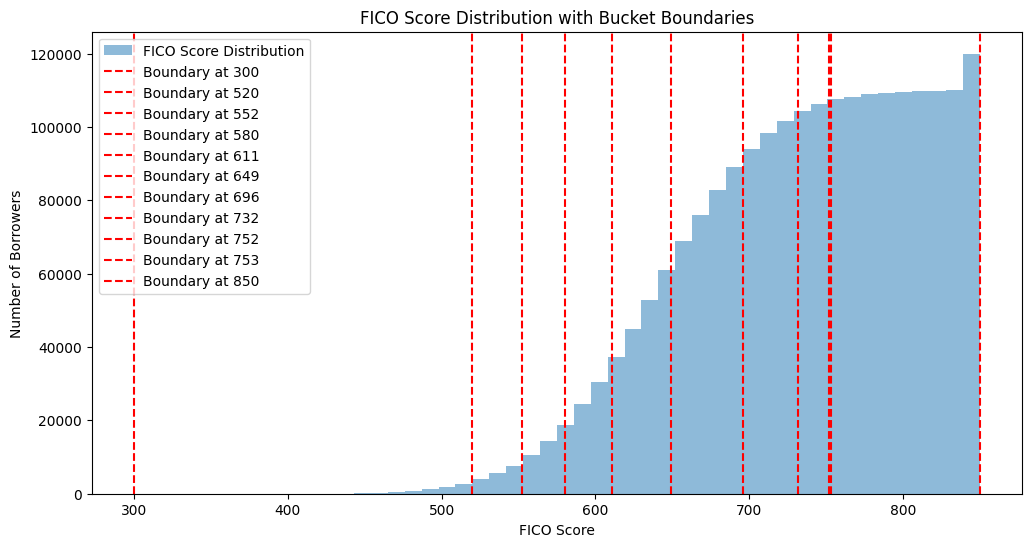

In [3]:
# Assume `buckets` contains the bucket boundaries and `default` and `total` contain cumulative sums
fico_scores = np.arange(300, 851)
defaults = np.array([default[i - 300] for i in fico_scores])
totals = np.array([total[i - 300] for i in fico_scores])

# Calculate the default rate for each FICO score
default_rate = np.divide(defaults, totals, out=np.zeros_like(defaults, dtype=float), where=totals != 0)

# Plot 1: FICO Score vs. Default Rate with Bucket Boundaries
plt.figure(figsize=(12, 6))
plt.plot(fico_scores, default_rate, label='Default Rate')
for boundary in buckets:
    plt.axvline(boundary, color='r', linestyle='--', label=f'Boundary at {boundary}')
plt.xlabel('FICO Score')
plt.ylabel('Default Rate')
plt.title('FICO Score vs. Default Rate with Bucket Boundaries')
plt.legend()
plt.show()

# Plot 2: FICO Score Distribution with Buckets
plt.figure(figsize=(12, 6))
plt.hist(fico_scores, bins=50, weights=totals, alpha=0.5, label='FICO Score Distribution')
for boundary in buckets:
    plt.axvline(boundary, color='r', linestyle='--', label=f'Boundary at {boundary}')
plt.xlabel('FICO Score')
plt.ylabel('Number of Borrowers')
plt.title('FICO Score Distribution with Bucket Boundaries')
plt.legend()
plt.show()